In [1]:
import matplotlib.pyplot as plt
import numpy as np

import rdkit
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs



#randomforestclassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


from mordred import Calculator, descriptors


ModuleNotFoundError: No module named 'mordred'

In [2]:
df = pd.read_csv('tested_molecules-1.csv')
smiles_good_inhibitor = df[df['ALDH1_inhibition'] == 1].reset_index()
smiles_bad_inhibitor = df[df['ALDH1_inhibition'] == 0].reset_index()

In [3]:
def plot_mol (smiles_df, molecule_index):
    smiles = smiles_df['SMILES'][molecule_index]
    mol =Chem.MolFromSmiles(smiles)
    Draw.MolToMPL(mol, size=(200, 200))


In [4]:
def plot_list_mol(smiles_df):
    mol_list = []
    for smiles in smiles_df:
        for smiles in smiles_df['SMILES']:    # assuming your column is called Smiles
            mol = Chem.MolFromSmiles(smiles)
            Chem.SanitizeMol(mol,sanitizeOps=Chem.SANITIZE_SYMMRINGS|Chem.SANITIZE_SETCONJUGATION|Chem.SANITIZE_SETHYBRIDIZATION)
            mol.Compute2DCoords()
            mol_list.append(mol)
            Draw.MolToMPL(mol, size=(200, 200))

In [5]:
data = df.copy(deep=True)
molecules = data.SMILES.apply(Chem.MolFromSmiles)
data.loc[:, 'MolLogP'] = molecules.apply(Descriptors.MolLogP)
data.loc[:, 'HeavyAtomCount'] = molecules.apply(Descriptors.HeavyAtomCount)
data.loc[:, 'HAccept'] = molecules.apply(Descriptors.NumHAcceptors)
data.loc[:, 'Heteroatoms'] = molecules.apply(Descriptors.NumHeteroatoms)
data.loc[:, 'HDonor'] = molecules.apply(Descriptors.NumHDonors)
data.loc[:, 'MolWt'] = molecules.apply(Descriptors.MolWt)
data.loc[:, 'RotableBonds'] = molecules.apply(Descriptors.NumRotatableBonds)
data.loc[:, 'RingCount'] = molecules.apply(Descriptors.RingCount)
data.loc[:, 'Ipc'] = molecules.apply(Descriptors.Ipc)
data.loc[:, 'HallKierAlpha'] = molecules.apply(Descriptors.HallKierAlpha)
data.loc[:, 'NumValenceElectrons'] = molecules.apply(Descriptors.NumValenceElectrons)
data.loc[:, 'SaturatedRings'] = molecules.apply(Descriptors.NumSaturatedRings)
data.loc[:, 'AliphaticRings'] = molecules.apply(Descriptors.NumAliphaticRings)
data.loc[:, 'AromaticRings'] = molecules.apply(Descriptors.NumAromaticRings)
data.loc[:, 'Heterocycles'] = molecules.apply(Descriptors.NumAromaticHeterocycles)
data.loc[:, 'AmideBonds'] = [AllChem.CalcNumAmideBonds(mol) for mol in molecules]
data.loc[:, 'LipinskiHBA'] = [AllChem.CalcNumLipinskiHBA(mol) for mol in molecules]
data.loc[:, 'LipinskiHBD'] = [AllChem.CalcNumLipinskiHBD(mol) for mol in molecules]
data.loc[:, 'MaxPartialCharge'] = [rdkit.Chem.Descriptors.MaxPartialCharge(mol, force=False) for mol in molecules]
data.loc[:, 'MinPartialCharge'] = [rdkit.Chem.Descriptors.MinPartialCharge(mol, force=False) for mol in molecules]


    
    
#Split data into Test data set and training data set before doing anything.
#X_train, X_test, y_train, y_test = train_test_split(data[features], data['ALDH1_inhibition'], stratify=data['ALDH1_inhibition'],test_size=0.25, random_state=42)

In [6]:
testdf = df.copy(deep=True)
molecules = testdf.SMILES.apply(Chem.MolFromSmiles)

calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
desc_names = calc.GetDescriptorNames()
    
Mol_descriptors =[]
for mol in molecules:
# Calculate all 200 descriptors for each molecule
    descriptors = calc.CalcDescriptors(mol)
    Mol_descriptors.append(descriptors)






df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
#df_with_200_descriptors['ALDH1_inhibition'] = df['ALDH1_inhibition']

df_boxplot = df_with_200_descriptors.select_dtypes(exclude=['object','string'])
for column in df_boxplot:
    plt.figure()
    df_boxplot.boxplot(by='ALDH1_inhibition',column= [column])

data_boxplot = data.select_dtypes(exclude=['object','string'])
for column in data_boxplot:
    plt.figure()
    data_boxplot.boxplot(by='ALDH1_inhibition',column= [column])

C:\Users\20213709\AppData\Local\miniconda3\envs\rdkitenv\lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


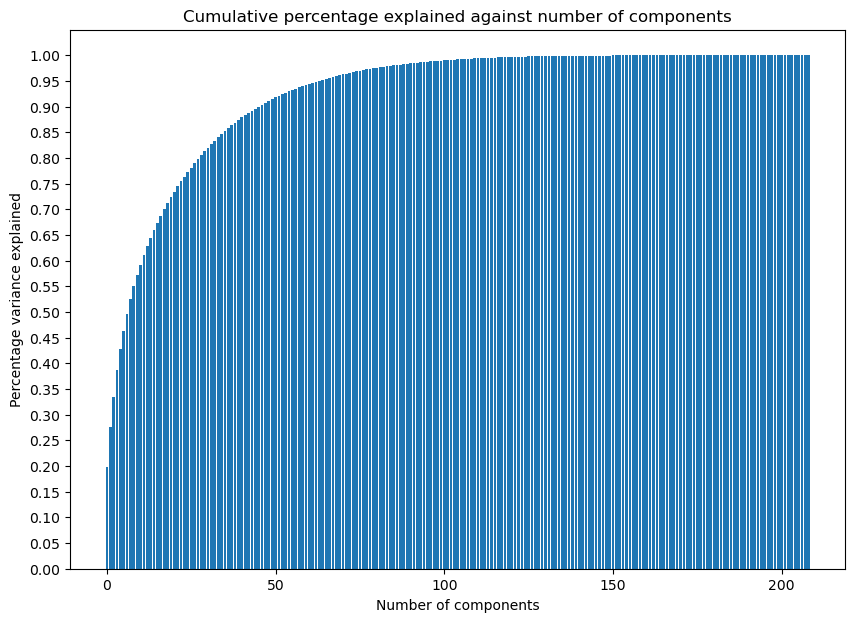

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
matrix_minmax_scaled = scaler.fit_transform(df_with_200_descriptors)
df_var_minmax_scaled = pd.DataFrame(matrix_minmax_scaled, columns=df_with_200_descriptors.columns)


from numpy import linalg as LA

covariance_matrix =df_var_minmax_scaled.cov().to_numpy()
w,v = LA.eig(covariance_matrix)
#print(w[0]/sum(w))
explained = np.cumsum(w/sum(w))
#print(explained)
amount_variables = [*range(len(explained))]

fig = plt.figure(figsize =(10, 7))
plt.bar(amount_variables, explained)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylabel('Percentage variance explained')
plt.xlabel('Number of components')
plt.title('Cumulative percentage explained against number of components')
plt.show()



In [ ]:
pca = decomposition.PCA(n_components=50)
PCA_minmax_scaled = pca.fit_transform(df_var_minmax_scaled)
load = pca.components_.T *np.sqrt(pca.explained_variance_)